In [38]:
from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian
from openfermion.ops import FermionOperator
from openfermion.transforms import bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

import numpy as np
import functools

In [39]:
sim = WavefunctionSimulator(random_seed=1337)

In [40]:
def solve_vqe(hamiltonian: PauliSum, numQubit, numLayer) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    theta_init = np.random.rand(2*numQubit*numLayer) * 2 * np.pi

    def ansatz_energy(theta_vec):
        p = None
        p = Program()
        for j in range(numLayer):
            for i in range(numQubit):
                p += RX(theta_vec[2*numQubit * j + 2 * i], i)
                p += RZ(theta_vec[2*numQubit * j + 2 * i + 1], i)
            for i in range(numQubit - 1):
                p += CNOT(i, i + 1)

        energy = sim.expectation(p, hamiltonian).real
        return energy

    theta_answer = minimize(ansatz_energy, theta_init).x
    return ansatz_energy(theta_answer)

In [41]:
def get_ground_energy(interaction_hamil, numQubit, numLayer):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator(random_seed=1337)
    solve_vqe(pauliop_hamil, numQubit, numLayer)


bond length:  0.7414  ground state energy:  None


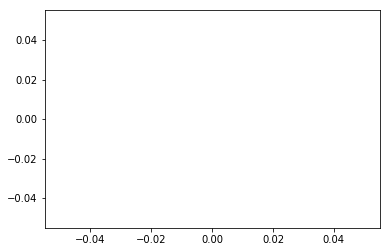

In [45]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = [.7414]
ground_energies = []

for bond_length in bond_lengths:
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    description = str(bond_length)
    h2_interaction_hamil = load_molecular_hamiltonian(geometry,
        basis,
        multiplicity,
        description,
        n_active_electrons=None,
        n_active_orbitals=None)
    
    ge = get_ground_energy(h2_interaction_hamil, 4, 4)
    ground_energies.append(ge)
    print('bond length: ', bond_length, ' ground state energy: ', ge)


plt.figure(0)
plt.plot(bond_length_arr, ground_energy_arr)
plt.show()